In [1]:
import os

import aeon
from aeon.datasets import load_from_ts_file

ModuleNotFoundError: No module named 'aeon'

In [1]:
import numpy as np
import scipy

In [3]:
list_of_ts_data = []
with open("ts_to_predict.txt") as f:
    for line in f:
        tmp = list(line.split(';'))[3:]
        list_of_ts_data.append(np.array(tmp, dtype = float))
        

In [3]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
        
)

df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"
)

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(list_of_ts_data[0]), prediction_length=12
)

NameError: name 'list_of_ts_data' is not defined

In [16]:
forecast.shape

torch.Size([1, 9, 12])

In [4]:
list_of_ts_data_res = []
with open("ts_results.txt") as f:
    for line in f:
        tmp = list(line.split(';'))[1:]
        list_of_ts_data_res.append(np.array(tmp, dtype = float))

In [18]:
list_of_ts_data_res[0]

array([1657.01533756, 1624.5372867 , 1585.22298748, 1674.19528411,
       1674.95508584, 1695.75984319, 1655.82305329, 1672.32714116,
       1650.60573475, 1738.65621381, 1710.37802985, 1683.41802154])

In [6]:
import matplotlib.pyplot as plt

In [7]:
plt.plot(list_of_ts_data_res[0])
plt.plot(forecast[0][8])

NameError: name 'list_of_ts_data_res' is not defined

In [63]:
pipeline.inner_model.encoder.block[1].layer[0]

T5LayerSelfAttention(
  (SelfAttention): T5Attention(
    (q): Linear(in_features=768, out_features=768, bias=False)
    (k): Linear(in_features=768, out_features=768, bias=False)
    (v): Linear(in_features=768, out_features=768, bias=False)
    (o): Linear(in_features=768, out_features=768, bias=False)
  )
  (layer_norm): T5LayerNorm()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [4]:
from torch import nn
class Custom_linear(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.layer = nn.Linear(in_features = weights.shape[1],
                               out_features =  weights.shape[0], bias = False)
        self.layer.weight = weights
        self.c = 0
        self.auto_cor_matrix = torch.zeros(768, 768)
        self.auto_cor_matrix = self.auto_cor_matrix.to('cuda')
        self.statistic = []
    def forward(self, x):
        self.c += 1

        tmp = x.view(-1,768)
        self.auto_cor_matrix += tmp.T @ tmp
        #self.statistic.append(tmp)
        
        return self.layer(x)
        
def process_linear_layer(linear_layer):
    weights = None
    for p in linear_layer.parameters():
            weights = p
    return Custom_linear(weights) 

def process_model(model):
    for i in range(12):
        
        model.encoder.block[i].layer[0].SelfAttention.q =\
        process_linear_layer(model.encoder.block[i].layer[0].SelfAttention.q)

        model.encoder.block[i].layer[0].SelfAttention.k =\
        process_linear_layer(model.encoder.block[i].layer[0].SelfAttention.k)

        model.encoder.block[i].layer[0].SelfAttention.v =\
        process_linear_layer(model.encoder.block[i].layer[0].SelfAttention.v)

        model.encoder.block[i].layer[0].SelfAttention.o =\
        process_linear_layer(model.encoder.block[i].layer[0].SelfAttention.o)


        model.decoder.block[i].layer[0].SelfAttention.q =\
        process_linear_layer(model.decoder.block[i].layer[0].SelfAttention.q)

        model.decoder.block[i].layer[0].SelfAttention.k =\
        process_linear_layer(model.decoder.block[i].layer[0].SelfAttention.k)

        model.decoder.block[i].layer[0].SelfAttention.v =\
        process_linear_layer(model.decoder.block[i].layer[0].SelfAttention.v)

        model.decoder.block[i].layer[0].SelfAttention.o =\
        process_linear_layer(model.decoder.block[i].layer[0].SelfAttention.o)

In [20]:
class Reduced_Linear(nn.Module):
    def __init__(self, dense_linear_layer, rank = 1000, type = 'matrix'):
        super(Reduced_Linear, self).__init__()
        
        matrix = None
        
        for p in dense_linear_layer.parameters():
            matrix = p.detach()

        if type == 'matrix':
        
            U, S, Vh = torch.linalg.svd(matrix.float(), full_matrices=False)
            S = S[:rank]
            U = U[:, :rank]
            Vh = Vh[:rank,]
            self.linear1 =  nn.Linear(in_features=matrix.shape[1], out_features=rank, bias=False)
            self.linear2 =  nn.Linear(in_features=rank, out_features=matrix.shape[0], bias=False)
            
            with torch.no_grad():
                for p in self.linear1.parameters():
                    p.copy_((torch.diag(S)@Vh).to('cuda'))
                
                for p in self.linear2.parameters():
                    p.copy_(U.to('cuda'))
            self.linear1 = self.linear1.to('cuda')
            self.linear2 = self.linear2.to('cuda')
        else:
            #X_v = torch.cat(dense_linear_layer.statistic).view(-1, 768)

            #x = torch.mean(X_v**2, axis = 0)
            
            #R_x = torch.cov(X_v).float().cpu().numpy()
            R_x = dense_linear_layer.auto_cor_matrix.float().cpu().numpy() / dense_linear_layer.c
            R_sq = scipy.linalg.sqrtm(R_x + np.diag(np.ones(768)/10)) #+ np.diag(np.ones(768)/10000000))
            #R_sq = np.sqrt(R_x)
            
            #R_fract_inv = np.diag(1 / np.sqrt(x.float().numpy()))
            R_fract_inv = np.linalg.inv(R_sq)
            
            Q = R_sq @ matrix.float().cpu().numpy()
            U, S, V = np.linalg.svd(Q)

            self.linear1 =  nn.Linear(in_features=matrix.shape[1], out_features=rank, bias=False)
            self.linear2 =  nn.Linear(in_features=rank, out_features=matrix.shape[0], bias=False)

            #Q_c = R_fract_inv @ U[:,:w//5] * S[None, :w//5] @ V[:w//5,:]

            with torch.no_grad():
                for p in self.linear1.parameters():
                    p.copy_(
                        (torch.diag(torch.tensor(S[:rank])).float()@ torch.tensor(V[:rank,:]).float()).to('cuda')
                    )
                
                for p in self.linear2.parameters():
                    p.copy_(
                        (torch.tensor(R_fract_inv @ U[:,:rank])).to('cuda')
                    )
            self.linear1 = self.linear1.to('cuda')
            self.linear2 = self.linear2.to('cuda')
            
            
            
                
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out

In [6]:
import numpy as np

In [7]:
def reduce_model(model, rank, type):
    for i in range(0,12):
        print(i)
        model.encoder.block[i].layer[0].SelfAttention.q =\
        Reduced_Linear(model.encoder.block[i].layer[0].SelfAttention.q, rank, type)

        model.encoder.block[i].layer[0].SelfAttention.k =\
        Reduced_Linear(model.encoder.block[i].layer[0].SelfAttention.k, rank, type)

        model.encoder.block[i].layer[0].SelfAttention.v =\
        Reduced_Linear(model.encoder.block[i].layer[0].SelfAttention.v, rank, type)

        model.encoder.block[i].layer[0].SelfAttention.o =\
        Reduced_Linear(model.encoder.block[i].layer[0].SelfAttention.o, rank, type)

        '''
        model.decoder.block[i].layer[0].SelfAttention.q =\
        Reduced_Linear(model.decoder.block[i].layer[0].SelfAttention.q, rank, type)

        model.decoder.block[i].layer[0].SelfAttention.k =\
        Reduced_Linear(model.decoder.block[i].layer[0].SelfAttention.k, rank, type)

        model.decoder.block[i].layer[0].SelfAttention.v =\
        Reduced_Linear(model.decoder.block[i].layer[0].SelfAttention.v, rank, type)

        model.decoder.block[i].layer[0].SelfAttention.o =\
        Reduced_Linear(model.decoder.block[i].layer[0].SelfAttention.o, rank, type)
        '''

In [8]:
def evaluate_method(data_train,data_test, method, rank):
    horizon = data_test.shape[1]

    pipeline = BaseChronosPipeline.from_pretrained(
            "amazon/chronos-bolt-base",
            device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
            torch_dtype=torch.bfloat16,
                
        )
    process_model(pipeline.inner_model)
    forecast = pipeline.predict(context=data_train.to('cuda'),
                                prediction_length=horizon)

    reduce_model(pipeline.inner_model, rank, method)
    
    pipeline.inner_model.float()
    forecast = pipeline.predict(context=data_train.to('cuda'),
                                prediction_length=horizon)
    
    forecast = forecast.float().cpu().numpy()[:,4]

    #dif = np.sqrt(np.sum((data_test - forecast)**2, axis = 1)) / np.mean(data_test, axis = 1)

    return forecast #dif.mean()

In [ ]:
evaluate_method()

In [26]:
pipeline = BaseChronosPipeline.from_pretrained(
            "amazon/chronos-bolt-base",
            device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
            torch_dtype=torch.bfloat16,
                
        )
process_model(pipeline.inner_model)
for raw in list_of_ts_data:
    forecast = pipeline.predict(
    context=torch.tensor(raw), prediction_length=12
)

In [98]:
a[48].shape

torch.Size([1, 1, 768])

In [32]:
X_v = torch.cat(a)

In [124]:
a = pipeline.inner_model.encoder.block[0].layer[0].SelfAttention.v.statistic
X_v = torch.cat(a)
R_x = (X_v.T @ X_v).float().numpy() / 768
R_sq = scipy.linalg.sqrtm(R_x + np.diag(np.ones(768)/100)) #+ #np.diag(np.ones(768)/50000000))
R_x[:4,:4] 

array([[ 6.5192580e-08,  9.8099314e-08, -3.0597050e-06, -3.9387182e-09],
       [ 9.8099314e-08,  2.9305616e-07,  1.6848246e-05, -3.5079818e-08],
       [-3.0597050e-06,  1.6848246e-05,  2.4088541e-02, -4.1325886e-05],
       [-3.9387182e-09, -3.5079818e-08, -4.1325886e-05,  1.0679165e-07]],
      dtype=float32)

In [126]:
a[0].shape

torch.Size([8, 768])

In [34]:
R_x[:3,:3]

array([[4.93600965e-08, 1.38243195e-09, 1.19325705e-08],
       [1.38243195e-09, 3.55765224e-07, 6.33299351e-08],
       [1.19325705e-08, 6.33299351e-08, 1.01979822e-07]], dtype=float32)

In [135]:
torch.mean(X_v[:,0]**2).float()

tensor(5.5879e-08)

In [165]:
R_sq

array([[ 1.71864076e-04+8.10421271e-10j,  2.67558616e-07-6.12729096e-10j,
         5.77820595e-06+4.02390824e-09j, ...,
        -3.61078685e-06-4.84604513e-09j,  2.90984939e-06-8.72760239e-10j,
        -2.29680052e-06+4.67488696e-10j],
       [ 2.67558616e-07-6.12729096e-10j,  3.73062028e-04+4.63261465e-10j,
         9.36825054e-06-3.04232594e-09j, ...,
        -3.31150740e-06+3.66391278e-09j, -3.37211150e-06+6.59861249e-10j,
        -1.45473093e-06-3.53450651e-10j],
       [ 5.77820595e-06+4.02390824e-09j,  9.36825054e-06-3.04232594e-09j,
         2.03720013e-04+1.99795318e-08j, ...,
        -4.42371943e-06-2.40616105e-08j, -8.38626951e-08-4.33343404e-09j,
         8.57452643e-07+2.32117750e-09j],
       ...,
       [-3.61078685e-06-4.84604513e-09j, -3.31150740e-06+3.66391278e-09j,
        -4.42371943e-06-2.40616105e-08j, ...,
         1.79024107e-04+2.89777110e-08j, -5.44849694e-06+5.21881108e-09j,
        -2.35658869e-07-2.79542431e-09j],
       [ 2.90984939e-06-8.72760239e-10j, -3.

In [228]:
pipeline.inner_model.float()
preds = []
for row in list_of_ts_data:
    forecast = pipeline.predict(
            context=torch.tensor(row), prediction_length=12
        )
    preds.append(forecast)

In [185]:
forecast.shape

torch.Size([1, 9, 12])

In [182]:
list_of_ts_data_res[0]

array([1657.01533756, 1624.5372867 , 1585.22298748, 1674.19528411,
       1674.95508584, 1695.75984319, 1655.82305329, 1672.32714116,
       1650.60573475, 1738.65621381, 1710.37802985, 1683.41802154])

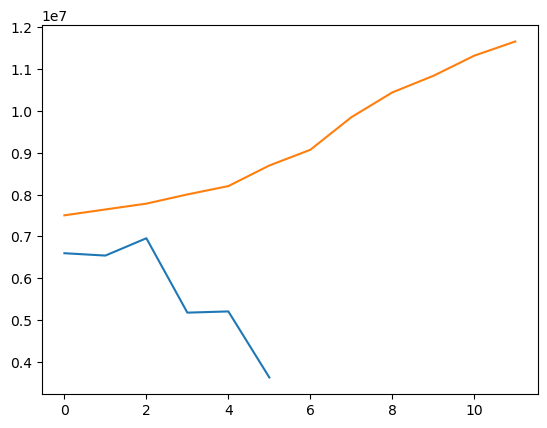

In [215]:
plt.plot(list_of_ts_data_res[70])
plt.plot(preds[70][0,4])

In [229]:
dif = 0
for i in range(70):
    cur_p = preds[i][0][4].numpy()
    cur_res = list_of_ts_data_res[i]
    len_ = min(12, len(cur_res))
    dif += np.sqrt(np.mean((cur_p[:len_] - cur_res[:len_])**2 )) / np.mean(cur_res[:len_])

In [168]:
512

512

In [127]:
import tarfile

In [21]:
import json
b = []
data_train = []
data_test = []
with open('taxi_data/taxi_30min/train/train.json', 'r') as f:
    for l in f:
        x = torch.tensor(json.loads(l)['target'])
        cur_train = []
        cur_test = []
        #cur_train = [x[:512], x[512:1024]]
        #cur_test = [x[512:512+10], x[1024:1024+10]]
        for i in range(10):
            cur_train.append(
                x[i+10:i+10+512]
            )
            cur_test.append(
                x[i+10+512:i+10+512+10]
            )
        data_train.append(torch.cat(cur_train).view(-1,512))
        data_test.append(torch.cat(cur_test).view(-1,10))
            
            
            

In [22]:
data_train = torch.cat(data_train).view(-1, 512)
data_test = torch.cat(data_test).view(-1, 10)

In [35]:
f = evaluate_method(data_train, data_test, 'matrix', 150)

0
1
2
3
4
5
6
7
8
9
10
11


In [36]:
np.mean(np.sqrt(np.mean((data_test.numpy() - f)**2, axis = 1)))

1.7865189

In [37]:
import matplotlib.pyplot as plt

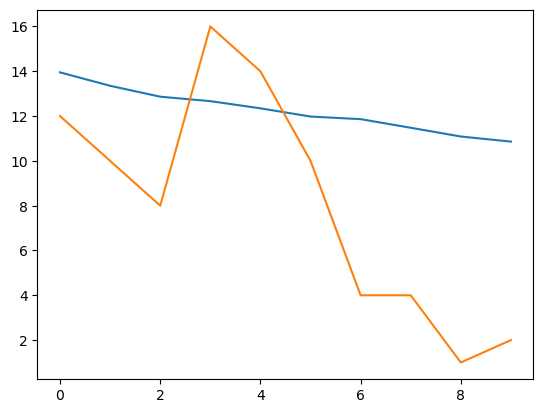

In [50]:
plt.plot(f[1000])
plt.plot(data_test.numpy()[1000])

In [199]:
len(data_train)

12140

In [11]:
pipeline = BaseChronosPipeline.from_pretrained(
            "amazon/chronos-bolt-base",
            device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
            torch_dtype=torch.bfloat16,
                
        )
process_model(pipeline.inner_model)

In [12]:
forecast = pipeline.predict(
            context=data_train.to('cuda'), prediction_length=10
        )

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [13]:
forecast.shape

torch.Size([1000, 9, 10])

In [17]:
a = pipeline.inner_model.encoder.block[1].layer[0].SelfAttention.k.auto_cor_matrix

#R_x = (X_v.T @ X_v).float().numpy() / 768
#R_sq = scipy.linalg.sqrtm(R_x + np.diag(np.ones(768)/100)) #+ #np.diag(np.ones(768)/50000000))
#R_x[:4,:4] 

In [16]:
np.linalg.cond(a.cpu().numpy())

52149363000000.0

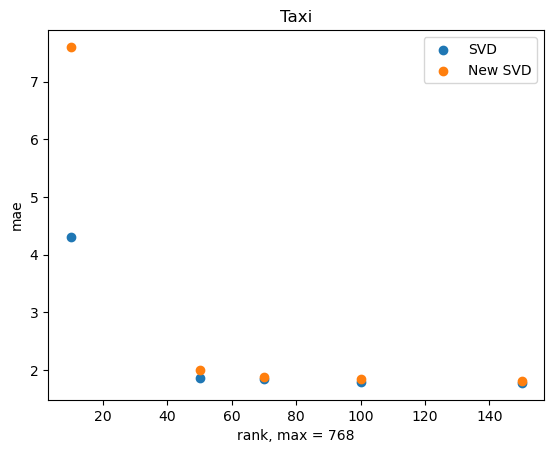

In [47]:
plt.scatter([10,50,70, 100, 150], [4.3, 1.86, 1.84, 1.79, 1.78], label = 'SVD')
plt.scatter([10,50,70, 100, 150], [7.6, 2, 1.89, 1.84, 1.81], label = 'New SVD')
plt.xlabel('rank, max = 768')
plt.ylabel('mae')
plt.title('Taxi')
plt.legend()